In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
train_path = 'dataset/train'
valid_path = 'dataset/valid'
test_path = 'dataset/test'

In [3]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)


Found 2515 images belonging to 36 classes.
Found 1417 images belonging to 36 classes.
Found 1188 images belonging to 36 classes.


In [4]:
imgs,labels = next(train_batches)

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

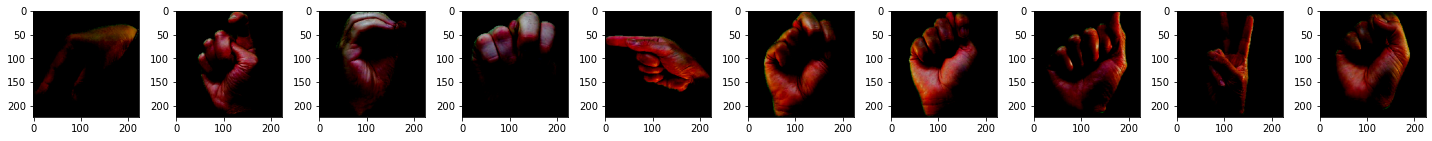

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.

In [6]:
plotImages(imgs[:10])
print(labels)

In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [8]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [15]:
x = mobile.layers[-6].output
output = Dense(units=36,activation='softmax')(x)

In [16]:
model = Model(inputs=mobile.input,outputs=output)

In [17]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [18]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [19]:
model.compile(optimizer = Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=50, verbose=2)

Epoch 1/50
252/252 - 331s - loss: 0.9323 - accuracy: 0.8004 - val_loss: 0.1319 - val_accuracy: 0.9944
Epoch 2/50
252/252 - 315s - loss: 0.1261 - accuracy: 0.9845 - val_loss: 0.0281 - val_accuracy: 1.0000
Epoch 3/50
252/252 - 321s - loss: 0.0560 - accuracy: 0.9972 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 4/50
252/252 - 305s - loss: 0.0310 - accuracy: 0.9992 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 5/50
252/252 - 229s - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/50
252/252 - 240s - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/50
252/252 - 233s - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 8/50
252/252 - 230s - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 9/50
252/252 - 234s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 7.2219e-04 - val_accuracy: 1.0000
Epoch 10/50
252/252 - 230s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 5.536

In [21]:
test_labels = test_batches.classes

In [ ]:
predictions = model.predict(x =test_batches, verbose=0)

In [ ]:
cm = confusion_matrix(y_true = test_labels, y_pred = predictions.argmax(axis=1))

In [ ]:
cm = confusion_matrix(y_true = test_labels, y_pred = predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confustion Matrix')

In [ ]:
import os.path
if os.path.isfile('ASLfinal.h5') is False:
    model.save('ASLfinal.h5')